# ML for passholder prediction

### Imports

In [1]:
import sys
import gc

from utils import utils
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler

from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from fast_ml.feature_engineering import FeatureEngineering_DateTime

from IPython.display import display, HTML

In [2]:
schema={
    'duration':'float64',
    'start_lat':'float64',
    'start_lon':'float64',
    'end_lat':'float64',
    'end_lon':'float64',
    'bike_id':'category',
    'plan_duration':'category',
    'trip_route_category':'category',
    'passholder_type':'category',
    'start_station':'category',
    'end_station':'category'
}

dates=['start_time', 'end_time']

load_train=pd.read_csv('/workspace/data/train_set_cleaned_no_out.csv', index_col='trip_id', dtype=schema, parse_dates=dates)

X_test =pd.read_csv('/workspace/data/test_set_cleaned_no_out.csv', index_col='trip_id', dtype=schema, parse_dates=dates)
# Features
X_train = load_train.loc[:, (load_train.columns != 'passholder_type') & (load_train.columns != 'plan_duration')]

# Label
y_train = load_train.loc[:, 'passholder_type']

In [3]:
X_train

,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,trip_route_category,start_station,end_station
trip_id,,,,,,,,,,,
101750280,35.0,2018-08-07 11:20:00,2018-08-07 11:55:00,33.748920,-118.275192,33.748920,-118.275192,06530,Round Trip,4127,4127
46560345,32.0,2017-09-17 17:51:00,2017-09-17 18:23:00,34.035679,-118.270813,34.047749,-118.243172,6683,One Way,3057,3062
120016336,6.0,2019-04-22 09:22:00,2019-04-22 09:28:00,34.046070,-118.233093,34.047749,-118.243172,06710,One Way,3022,3062
129547190,138.0,2019-09-22 11:27:00,2019-09-22 13:45:00,34.062580,-118.290092,34.059689,-118.294662,17068,One Way,4304,4311
136619463,14.0,2020-01-31 17:11:00,2020-01-31 17:25:00,34.026291,-118.277687,34.021660,-118.278687,18841,One Way,4266,4443
...,...,...,...,...,...,...,...,...,...,...,...
83666862,17.0,2018-04-25 18:32:00,2018-04-25 18:49:00,34.049889,-118.255882,34.074829,-118.258728,06505,One Way,3032,4220
132547303,9.0,2019-11-12 16:49:10,2019-11-12 16:58:51,34.039188,-118.232529,34.056610,-118.237213,18348,One Way,3036,3014
67332628,6.0,2018-01-13 15:49:00,2018-01-13 15:55:00,34.049889,-118.255882,34.050480,-118.254593,05718,One Way,3032,3007


In [4]:
set(X_train.columns)-set(X_test.columns)

set()

In [5]:
# gc
del load_train

### Encoding

In [6]:
#Instantiate
dt_fe = FeatureEngineering_DateTime()

In [7]:
datetime_vars=['start_time', 'end_time']
dt_fe.fit(X_train, datetime_variables=datetime_vars, prefix = 'default')
X_train = dt_fe.transform(X_train)

/usr/local/lib/python3.9/dist-packages/fast_ml/feature_engineering.py:382: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[pfx+f] = getattr(df[var].dt, f)
/usr/local/lib/python3.9/dist-packages/fast_ml/feature_engineering.py:382: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[pfx+f] = getattr(df[var].dt, f)


In [32]:
datetime_vars=['start_time', 'end_time']
dt_fe.fit(X_test, datetime_variables=datetime_vars, prefix = 'default')
X_test = dt_fe.transform(X_test)

NameError: name 'dt_fe' is not defined

In [9]:
pd.options.display.max_columns = None
display(X_train)

,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,trip_route_category,start_station,end_station,start_time:year,start_time:quarter,start_time:month,start_time:day,start_time:day_of_week,start_time:day_of_year,start_time:weekofyear,start_time:is_month_end,start_time:is_month_start,start_time:is_quarter_end,start_time:is_quarter_start,start_time:is_year_end,start_time:is_year_start,start_time:time,start_time:hour,start_time:minute,start_time:second,start_time:is_weekend,start_time:day_part,end_time:year,end_time:quarter,end_time:month,end_time:day,end_time:day_of_week,end_time:day_of_year,end_time:weekofyear,end_time:is_month_end,end_time:is_month_start,end_time:is_quarter_end,end_time:is_quarter_start,end_time:is_year_end,end_time:is_year_start,end_time:time,end_time:hour,end_time:minute,end_time:second,end_time:is_weekend,end_time:day_part
trip_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
101750280,35.0,2018-08-07 11:20:00,2018-08-07 11:55:00,33.748920,-118.275192,33.748920,-118.275192,06530,Round Trip,4127,4127,2018,3,8,7,1,219,32,False,False,False,False,False,False,11:20:00,11,20,0,0,noon,2018,3,8,7,1,219,32,False,False,False,False,False,False,11:55:00,11,55,0,0,noon
46560345,32.0,2017-09-17 17:51:00,2017-09-17 18:23:00,34.035679,-118.270813,34.047749,-118.243172,6683,One Way,3057,3062,2017,3,9,17,6,260,37,False,False,False,False,False,False,17:51:00,17,51,0,1,evening,2017,3,9,17,6,260,37,False,False,False,False,False,False,18:23:00,18,23,0,1,evening
120016336,6.0,2019-04-22 09:22:00,2019-04-22 09:28:00,34.046070,-118.233093,34.047749,-118.243172,06710,One Way,3022,3062,2019,2,4,22,0,112,17,False,False,False,False,False,False,09:22:00,9,22,0,0,late morning,2019,2,4,22,0,112,17,False,False,False,False,False,False,09:28:00,9,28,0,0,late morning
129547190,138.0,2019-09-22 11:27:00,2019-09-22 13:45:00,34.062580,-118.290092,34.059689,-118.294662,17068,One Way,4304,4311,2019,3,9,22,6,265,38,False,False,False,False,False,False,11:27:00,11,27,0,1,noon,2019,3,9,22,6,265,38,False,False,False,False,False,False,13:45:00,13,45,0,1,noon
136619463,14.0,2020-01-31 17:11:00,2020-01-31 17:25:00,34.026291,-118.277687,34.021660,-118.278687,18841,One Way,4266,4443,2020,1,1,31,4,31,5,True,False,False,False,False,False,17:11:00,17,11,0,0,evening,2020,1,1,31,4,31,5,True,False,False,False,False,False,17:25:00,17,25,0,0,evening
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83666862,17.0,2018-04-25 18:32:00,2018-04-25 18:49:00,34.049889,-118.255882,34.074829,-118.258728,06505,One Way,3032,4220,2018,2,4,25,2,115,17,False,False,False,False,False,False,18:32:00,18,32,0,0,evening,2018,2,4,25,2,115,17,False,False,False,False,False,False,18:49:00,18,49,0,0,evening
132547303,9.0,2019-11-12 16:49:10,2019-11-12 16:58:51,34.039188,-118.232529,34.056610,-118.237213,18348,One Way,3036,3014,2019,4,11,12,1,316,46,False,False,False,False,False,False,16:49:10,16,49,10,0,afternoon,2019,4,11,12,1,316,46,False,False,False,False,False,False,16:58:51,16,58,51,0,afternoon
67332628,6.0,2018-01-13 15:49:00,2018-01-13 15:55:00,34.049889,-118.255882,34.050480,-118.254593,05718,One Way,3032,3007,2018,1,1,13,5,13,2,False,False,False,False,False,False,15:49:00,15,49,0,1,afternoon,2018,1,1,13,5,13,2,False,False,False,False,False,False,15:55:00,15,55,0,1,afternoon


In [10]:
for i, col in enumerate(X_train.columns):
    if (X_test[col].dtype == 'category'):
        test_c=set(X_test[col].cat.categories)
        train_c=set(X_train[col].cat.categories)
        compare_sets=(test_c-train_c)

        if(compare_sets == set()):
            continue
        else:
            print(f'Column {col} is has this differences: \n\t > {compare_sets}')


Column bike_id is has this differences: 
	 > {'15255', '15961', '16589', '15150', 'Dock Block 1', '15261', '15229a', '15917', '13658', '16172', '15139', '15611', '15241b', '16037', '17144'}
Column start_station is has this differences: 
	 > {'4362'}
Column end_station is has this differences: 
	 > {'4592', '4362'}


In [11]:
drop=[  
    'start_station',
    'end_station',
    'bike_id',
    'start_time',
    'end_time',
    'start_lat',
    'start_lon',
    'end_lat',
    'end_lon',
    'end_time:day_of_year',
    'end_time:day_part',
    'end_time:second',
    'end_time:minute',
    'end_time:time',
    'end_time:is_month_end',
    'end_time:is_month_start',
    'end_time:is_quarter_end',
    'end_time:is_quarter_start',
    'end_time:is_year_end',
    'end_time:is_year_start',
    'end_time:weekofyear',
    'end_time:quarter',
    'start_time:day_of_year',
    'start_time:day_part',
    'start_time:second',
    'start_time:minute',
    'start_time:time',
    'start_time:is_month_start',
    'start_time:is_month_start',
    'start_time:is_quarter_start',
    'start_time:is_quarter_start',
    'start_time:is_year_start',
    'start_time:is_year_start',
    'start_time:weekofyear',
    'start_time:quarter'
    ]


X_train=X_train.drop((drop), axis=1)
X_test=X_test.drop(drop, axis=1)

In [12]:
# Pre-processing functions

def aling_dfs(train, test):
        train_aligned, right_aligned = train.align(test, join="left", axis=1)

        return (train_aligned, right_aligned)


def categorical_imputer(categoricals_df, cols):
        categoricals_df=categoricals_df.loc[:, cols]
        imputer=SimpleImputer(strategy='most_frequent')
        imputed_nans=imputer.fit_transform(categoricals_df)
        return imputed_nans

def categorical_encoder(categoricals_df):
        encoder= OneHotEncoder(handle_unknown='error', sparse_output=False)
        categoricals_encoded=encoder.fit_transform(categoricals_df)

        return categoricals_encoded #END categorical_encoder()

def df_scaler(df): # Scale
        #scaler=RobustScaler()
        #df_scaled=scaler.fit_transform(df)
        transformer = RobustScaler().fit(df)
        df_scaled=transformer.transform(df)

        return df_scaled # END df_scaler()

In [13]:
# Align
train_aligned, test_aligned=aling_dfs(X_train, X_test)

In [14]:
del X_train
del X_test

In [15]:
# Impute categoricals
cat_X_test=['trip_route_category']
cat_X_train=['trip_route_category']

train_imputed_categoricals=categorical_imputer(train_aligned, cat_X_train)
test_imputed_categoricals=categorical_imputer(test_aligned, cat_X_test)

In [16]:
# Scale numericals
numericals=[
    'duration',
    'start_time:year',
    'start_time:month',
    'start_time:day',
    'start_time:day_of_week',
    'start_time:is_month_end',
    'start_time:is_quarter_end',
    'start_time:is_year_end',
    'start_time:hour',
    'start_time:is_weekend',
    'end_time:year',
    'end_time:month',
    'end_time:day',
    'end_time:day_of_week',
    'end_time:hour',
    'end_time:is_weekend'
 ]

numericals_scaled_train=df_scaler(train_aligned.loc[:, numericals])

In [17]:
numericals_scaled_test=df_scaler(test_aligned.loc[:, numericals])

In [18]:
del train_aligned
del test_aligned

In [19]:
# Encode categoricals
categoricals_encoded_train=categorical_encoder(train_imputed_categoricals)
categoricals_encoded_test=categorical_encoder(test_imputed_categoricals)

In [20]:
del train_imputed_categoricals
del test_imputed_categoricals

In [21]:
categoricals_scaled_train=df_scaler(categoricals_encoded_train)

In [22]:
del categoricals_encoded_train

In [23]:
categoricals_scaled_test=df_scaler(categoricals_encoded_test)

In [24]:
del categoricals_encoded_test

In [28]:
gc.get_count()

(592, 3, 2)

In [25]:
train_output=np.concatenate([categoricals_scaled_train, numericals_scaled_train], axis=1)
#train_output=np.concatenate([cat_train, nums_train], axis=1)
#test_output=np.concatenate([cat_test, nums_test], axis=1)

In [26]:
del categoricals_scaled_train
del numericals_scaled_train

In [27]:
test_output=np.concatenate([categoricals_scaled_test, numericals_scaled_test], axis=1)

In [28]:
del categoricals_scaled_test
del numericals_scaled_test

In [36]:
np.save('/workspace/data/test_output.npy', test_output)
np.save('/workspace/data/train_output.npy', train_output)

### Resampling strategies

In [2]:
schema={
    'duration':'float64',
    'start_lat':'float64',
    'start_lon':'float64',
    'end_lat':'float64',
    'end_lon':'float64',
    'bike_id':'category',
    'plan_duration':'category',
    'trip_route_category':'category',
    'passholder_type':'category',
    'start_station':'category',
    'end_station':'category'
}

dates=['start_time', 'end_time']

# Load DF's
y_train=pd.read_csv('/workspace/data/train_set_cleaned_no_out.csv', index_col='trip_id', dtype=schema, parse_dates=dates)
X_train=np.load('/workspace/data/train_output.npy')

In [5]:
y_train[['passholder_type']].value_counts()

passholder_type
Monthly Pass       387279
Walk-up            203867
One Day Pass        39888
Annual Pass         32973
Flex Pass           11420
dtype: int64

In [3]:
# RandomOverSampling
#under = RandomUnderSampler(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy='not minority', random_state=1)
# fit and apply the transform
X_under, y_under = under.fit_resample(X_train, y_train[['passholder_type']])

In [4]:
#np.sum(y_under, axis=0)
y_under

,passholder_type
0,Annual Pass
1,Annual Pass
2,Annual Pass
3,Annual Pass
4,Annual Pass
...,...
57095,Walk-up
57096,Walk-up
57097,Walk-up
57098,Walk-up


<AxesSubplot: >

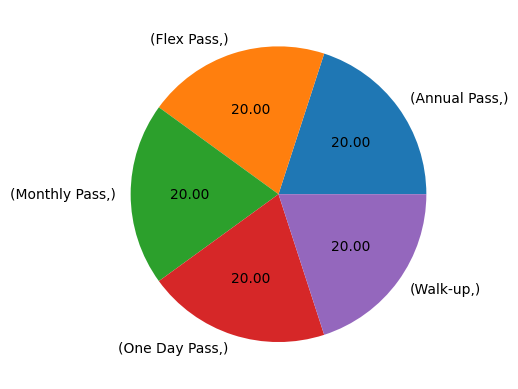

In [5]:
autopct="%.2f"
pd.DataFrame(y_under).value_counts().plot.pie(autopct=autopct)

In [70]:
# NearMiss
from imblearn.under_sampling import NearMiss
nm3 = NearMiss(version=3, sampling_strategy='not minority')
X_resampled_nm3, y_resampled_nm3 = nm3.fit_resample(train_output, y_train[['passholder_type']])

/usr/local/lib/python3.9/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


In [71]:
(np.sum(y_resampled_nm3, axis=0), pd.DataFrame(y_resampled_nm3).value_counts())

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return reduction(axis=axis, out=out, **passkwargs)


(Series([], dtype: float64),
 passholder_type
 Flex Pass          11420
 Monthly Pass       11420
 Walk-up            11420
 One Day Pass        6654
 Annual Pass         6105
 dtype: int64)

<AxesSubplot: >

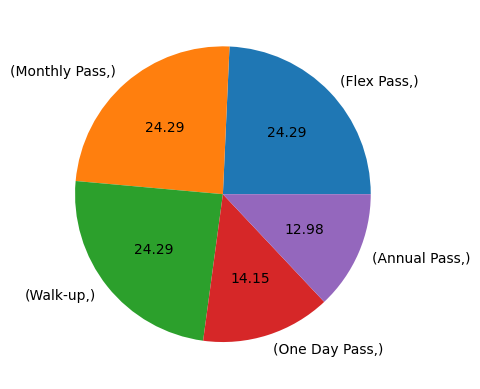

In [72]:
autopct="%.2f"
pd.DataFrame(y_resampled_nm3).value_counts().plot.pie(autopct=autopct)

### Training

#### Baseline model

In [9]:
y_under

,passholder_type
0,Annual Pass
1,Annual Pass
2,Annual Pass
3,Annual Pass
4,Annual Pass
...,...
57095,Walk-up
57096,Walk-up
57097,Walk-up
57098,Walk-up


In [117]:
# define model with resampled data
model = DecisionTreeClassifier()
# Encode Labels
label_encoder=LabelEncoder()
le_y_under=label_encoder.fit_transform(y_under)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_under, le_y_under, scoring='roc_auc_ovo', cv=cv, n_jobs=-1) # summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean ROC AUC: 0.644


In [118]:
list(label_encoder.classes_)

['Annual Pass', 'Flex Pass', 'Monthly Pass', 'One Day Pass', 'Walk-up']

In [123]:
label_encoder.transform(['Flex Pass', 'Annual Pass', 'Monthly Pass', 'One Day Pass', 'Walk-up'])

array([1, 0, 2, 3, 4])

In [125]:
# BAGGING
# define the model
model = BaggingClassifier()
# Encode Labels
label_encoder=LabelEncoder()
le_y_under=label_encoder.fit_transform(y_under)
# evaluate the model
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
n_scores = cross_val_score(model, X_under, le_y_under, scoring='roc_auc_ovo', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.778 (0.003)


In [6]:
# BAGGING Hyper Tuning

# Encode Labels
label_encoder=LabelEncoder()
le_y_under=label_encoder.fit_transform(y_under)

# get a list of models to evaluate
def get_models():
 models = dict()
 # define number of trees to consider
 n_trees = [10, 50, 100, 300, 500, 1000]
 for n in n_trees:
    models[str(n)] = BaggingClassifier(n_estimators=n)
 return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
 # define the evaluation procedure
 cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
 # evaluate the model and collect the results
 scores = cross_val_score(model, X, y, scoring='roc_auc_ovo', cv=cv, n_jobs=-1)
 return scores
 
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
 # evaluate the model
 scores = evaluate_model(model,X_under, le_y_under)
 # store the results
 results.append(scores)
 names.append(name)
 # summarize the performance along the way
 print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


>10 0.777 (0.003)
>50 0.801 (0.003)
>100 0.805 (0.002)


/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>300 0.807 (0.002)


/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>500 0.808 (0.002)


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

In [9]:
# BAGGING Hyper Tuning w/ Grid Search

# Encode Labels
label_encoder=LabelEncoder()
le_y_under=label_encoder.fit_transform(y_under)

bagging=BaggingClassifier()

param_grid = {
    'n_estimators': [10, 50, 100, 300, 500, 1000],
    'max_samples': [0.3, 0.6, 1.0]
}

# STRATEGY 1: Grid Search + CV
model_grid = GridSearchCV(bagging, param_grid=param_grid, cv=7, scoring='roc_auc_ovo',)
model_grid.fit(X_under, le_y_under)

 
 # summarize the performance along the way
# print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
#plt.boxplot(results, labels=names, showmeans=True)
#plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=7, estimator=BaggingClassifier(),
             param_grid={'max_samples': [0.3, 0.6, 1.0],
                         'n_estimators': [10, 50, 100, 300, 500, 1000]},
             scoring='roc_auc_ovo')

In [10]:
print("Best params: "+str(model_grid.best_params_))
print("Best Score: "+str(model_grid.best_score_)+'\n')

scores = pd.DataFrame(model_grid.cv_results_)
scores

Best params: {'max_samples': 0.3, 'n_estimators': 1000}
Best Score: 0.8200631139925727



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_samples,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
0,0.591291,0.014219,0.027570,0.001387,0.3,10,"{'max_samples': 0.3, 'n_estimators': 10}",0.785353,0.782491,0.779905,0.784224,0.782796,0.784295,0.778135,0.782457,0.002396,16
1,2.939334,0.018475,0.090766,0.001700,0.3,50,"{'max_samples': 0.3, 'n_estimators': 50}",0.814498,0.815125,0.808266,0.812054,0.812286,0.814407,0.808122,0.812108,0.002693,8
2,5.874013,0.043185,0.169580,0.001192,0.3,100,"{'max_samples': 0.3, 'n_estimators': 100}",0.817195,0.819755,0.811617,0.817236,0.816570,0.818565,0.810712,0.815950,0.003188,4
3,17.797449,0.290321,0.495765,0.019433,0.3,300,"{'max_samples': 0.3, 'n_estimators': 300}",0.820216,0.822028,0.816046,0.819753,0.819255,0.822197,0.815406,0.819272,0.002468,3
4,29.430030,0.296988,0.791967,0.002264,0.3,500,"{'max_samples': 0.3, 'n_estimators': 500}",0.821062,0.822412,0.816791,0.820692,0.819843,0.822184,0.815375,0.819765,0.002493,2
5,58.913770,0.804110,1.611593,0.028043,0.3,1000,"{'max_samples': 0.3, 'n_estimators': 1000}",0.821448,0.822353,0.816643,0.820927,0.819888,0.823096,0.816087,0.820063,0.002525,1
6,1.018018,0.006247,0.028280,0.000760,0.6,10,"{'max_samples': 0.6, 'n_estimators': 10}",0.779866,0.780449,0.776725,0.782574,0.782530,0.783026,0.777328,0.780357,0.002372,17
7,5.164537,0.094142,0.102725,0.002546,0.6,50,"{'max_samples': 0.6, 'n_estimators': 50}",0.809120,0.808960,0.804035,0.807181,0.806688,0.811171,0.800558,0.806816,0.003293,11
8,10.153609,0.026137,0.190653,0.002418,0.6,100,"{'max_samples': 0.6, 'n_estimators': 100}",0.810866,0.812269,0.807364,0.811731,0.808705,0.813743,0.806372,0.810150,0.002522,9
9,30.409465,0.050185,0.548780,0.003069,0.6,300,"{'max_samples': 0.6, 'n_estimators': 300}",0.813713,0.815368,0.809715,0.814047,0.812618,0.816333,0.808008,0.812829,0.002777,7


In [16]:
print("Best Score: "+str(model_grid.best_params_)+'\n')

Best Score: {'max_samples': 0.3, 'n_estimators': 1000}



In [17]:
# BAGGING Hyper Tuning w/ Grid Search

label_encoder=LabelEncoder()
le_y_under=label_encoder.fit_transform(y_under)

bagging_2=BaggingClassifier()

param_grid = {
    'n_estimators': [1000, 1500, 2000],
    'max_samples': [0.3]
}

model_grid_2 = GridSearchCV(bagging, param_grid=param_grid, cv=7, scoring='roc_auc_ovo',)
model_grid_2.fit(X_under, le_y_under)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=7, estimator=BaggingClassifier(),
             param_grid={'max_samples': [0.3],
                         'n_estimators': [1000, 1500, 2000]},
             scoring='roc_auc_ovo')

In [18]:
print("Best params: "+str(model_grid_2.best_params_))
print("Best Score: "+str(model_grid_2.best_score_)+'\n')

scores_2 = pd.DataFrame(model_grid_2.cv_results_)
scores_2

Best params: {'max_samples': 0.3, 'n_estimators': 2000}
Best Score: 0.8205091657304625



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_samples,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
0,59.284509,0.422291,1.616113,0.074452,0.3,1000,"{'max_samples': 0.3, 'n_estimators': 1000}",0.821056,0.822654,0.817384,0.821458,0.820268,0.823003,0.815851,0.820239,0.002479,3
1,89.170319,0.486918,2.586479,0.170092,0.3,1500,"{'max_samples': 0.3, 'n_estimators': 1500}",0.821080,0.823085,0.817341,0.821355,0.820309,0.823124,0.816191,0.820355,0.002481,2
2,118.742305,0.533713,3.525511,0.313141,0.3,2000,"{'max_samples': 0.3, 'n_estimators': 2000}",0.821528,0.823120,0.817235,0.821614,0.820777,0.823259,0.816031,0.820509,0.002605,1


In [20]:
print("Best Score: "+str(model_grid_2.best_params_)+'\n')

Best Score: {'max_samples': 0.3, 'n_estimators': 2000}



In [46]:
# evaluate a model
def evaluate_model(X, y, model):
 # define evaluation procedure
 cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
 # evaluate model
 scores = cross_val_score(model, train_output, y_train, scoring='roc_auc_ovo', cv=cv, n_jobs=-1)
 return scores
 
# define models to test
def get_models():
 models, names = list(), list()
 # LDA
 models.append(LinearDiscriminantAnalysis())
 names.append('LDA')
 # SVM
 models.append(LinearSVC())
 names.append('SVM')
 # Bagging
 models.append(BaggingClassifier(n_estimators=1000))
 names.append('BAG')
 # RF
 models.append(RandomForestClassifier(n_estimators=1000))
 names.append('RF')
 # ET
 models.append(ExtraTreesClassifier(n_estimators=1000))
 names.append('ET')
 return models, names
 

# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
 # evaluate the model and store results
 scores = evaluate_model(train_output, y_train, models[i])
 results.append(scores)

 # summarize performance
 print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))
# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

>LDA 0.756 (0.001)


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_scorer.py", line 115, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_scorer.py", line 316, in _score
    y_pred = method_caller(clf, "predict_proba", X)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

  warnings.warn(
/usr/local/lib/python3.9/dist-packages/s

In [67]:
model.fit(train_output, y_train)

LogisticRegression(C=0.5, max_iter=1000, multi_class='multinomial')

In [71]:
test_output[:3]

array([[-1.        ,  1.        , -0.05555556, -1.        , -1.        ,
        -1.        ,  0.75      ,  0.        ,  0.        ,  0.        ,
        -2.14285714,  1.        , -1.        , -1.        , -1.        ,
         0.75      , -2.14285714,  1.        ],
       [ 0.        ,  0.        ,  0.22222222, -1.        , -1.        ,
        -1.        ,  0.75      ,  0.        ,  0.        ,  0.        ,
        -2.14285714,  1.        , -1.        , -1.        , -1.        ,
         0.75      , -2.14285714,  1.        ],
       [ 0.        ,  0.        ,  0.38888889, -1.        , -1.        ,
        -1.        ,  0.75      ,  0.        ,  0.        ,  0.        ,
        -2.14285714,  1.        , -1.        , -1.        , -1.        ,
         0.75      , -2.14285714,  1.        ]])

In [81]:
y_pred=model.predict_proba(test_output)


#### AdaBoost Model

In [29]:
# BAGGING Hyper Tuning w/ Grid Search

label_encoder=LabelEncoder()
le_y_under=label_encoder.fit_transform(y_under)

param_grid = {
    'n_estimators': [50, 100, 200, 250, 500],
    'learning_rate': [0.6, 0.3, 0.1, 0.01, 0.001, 0.0001],
    'random_state': [1437]
}

ADB_model = AdaBoostClassifier()

ADA_model_grid = GridSearchCV(ADB_model, param_grid=param_grid, cv=7, scoring='roc_auc_ovo',)
ADA_model_grid.fit(X_under, le_y_under)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=7, estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [0.6, 0.3, 0.1, 0.01, 0.001, 0.0001],
                         'n_estimators': [50, 100, 200, 250, 500],
                         'random_state': [1437]},
             scoring='roc_auc_ovo')